In [52]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime
import re
%matplotlib inline 

In [2]:
def strip_tags(soup, tags):
    for tag in tags:
        for match in soup.findAll(tag):
            match.replaceWithChildren()

soup = BeautifulSoup("""
    <td>
    <div align="center">W. Force</div>
    </td>
    <td>
    <div align="center">5</div>
    </td>
    <td>
    <div align="center">18/2/06</div>
    </td>
    """, 'html.parser' )          
strip_tags(soup, ["div", "invalid"])
print(soup)


<td>
W. Force
</td>
<td>
5
</td>
<td>
18/2/06
</td>



In [8]:
 ##### Read results from www.superxv.com into DataFrame
teams_1 = []
teams_2 = []
scores_1 = []
scores_2 = []
dates = []
for year in [str(y) for y in range(2006, 2018)]:
    url = 'http://www.superxv.com/results/{year}-super-rugby-results/'.format(year=year)
    page = requests.get(url)
    if page.status_code != 200:
        print('Error downloading {url}'.format(url=url))
    else:
        print('Successfully downloaded {url}'.format(url=url))
        for table in BeautifulSoup(page.content, 'html.parser').find_all('table'):
            strip_tags(table, ["div"])
            for row in table.find_all('tr')[1:]:
                entries = row.find_all('td')
                if entries[0].text.strip() not in ['Bye', 'Not playing' ,'']: # and entries[1] = '':
                    teams_1.append(entries[0].text.strip().replace('\n',' '))
                    teams_2.append(entries[3].text.strip().replace('\n',' '))
                    scores_1.append(entries[1].text.strip())
                    scores_2.append(entries[4].text.strip())
                    dates.append(entries[5].text.strip())
df = pd.DataFrame({
        'date':dates,
        'team_1':teams_1,
        'team_2':teams_2,
        'score_1':scores_1,
        'score_2':scores_2})

Successfully downloaded http://www.superxv.com/results/2006-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2007-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2008-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2009-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2010-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2011-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2012-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2013-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2014-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2015-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2016-super-rugby-results/
Successfully downloaded http://www.superxv.com/results/2017-super-rugby-results/


In [9]:
########### Clean and format dates
df.date[df.date == "29/3/088"] = "29/03/2008"
df.date[df.date == "00/05/09"] = "09/05/09"
df.date[df.date == "0907/16"] = "09/07/16"
df.date = pd.to_datetime(df.date)
df = df.drop_duplicates() # 2007-05-05	10	36	Stormers	Sharks is duplicated
df['year'] = df.date.dt.year
df.groupby('year').count()

,date,score_1,score_2,team_1,team_2
year,,,,,
2006,94,94,94,94,94
2007,94,94,94,94,94
2008,94,94,94,94,94
2009,94,94,94,94,94
2010,94,94,94,94,94
2011,125,125,125,125,125
2012,125,125,125,125,125
2013,125,125,125,125,125
2014,125,125,125,125,125


In [13]:
#### Clean and format team names
pattern = "([A-Z][a-z]*)\W*$"
df.team_1 = df.team_1.str.extract(pattern)
df.team_2 = df.team_2.str.extract(pattern)
df.team_1[df.team_1 == 'Cats'] = 'Lions' 
df.team_2[df.team_2 == 'Cats'] = 'Lions' 

teams = pd.concat([df.team_1, df.team_2])
teams.groupby(teams).count().sort_values(ascending=False)

C:\Users\Liam\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Liam\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Crusaders      179
Sharks         172
Chiefs         172
Hurricanes     171
Bulls          171
Brumbies       170
Waratahs       170
Highlanders    168
Stormers       168
Reds           166
Blues          165
Cheetahs       163
Force          162
Lions          149
Rebels          97
Kings           33
Jaguares        17
Sunwolves       17
dtype: int64

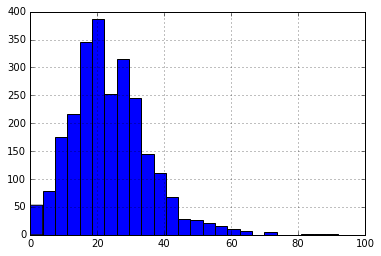

In [75]:
### Clean and format scores
df.set_value(151, 'score_1', 9)
df.set_value(151, 'score_2', 14)
df.score_1 = pd.to_numeric(df.score_1)
df.score_2 = pd.to_numeric(df.score_2)

pd.concat([df.score_1, df.score_2]).hist(bins=25)
#(df.score_1 - df.score_2).abs().hist(bins=25)

date       datetime64[ns]
score_1             int64
score_2             int64
team_1             object
team_2             object
year                int64
dtype: object